# Уменьшение потребления электроэнергии на этапе обработки стали для металлургического комбината
<b>Источник данных: Yandex Практикум</b>

## Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
#from verstack.stratified_continuous_split import scsplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU
from tensorflow import keras
from sklearn import tree

In [3]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

## Исследовательский анализ данных (EDA)

<b>Добавим класс для исследования данных</b>

In [4]:
class DataFrameCheck:
    """
    Класс для выполнения базовых проверок датасета:
    1) Наличие дубликатов
    2) Проверка пропусков
    3) Общая информация
    4) Вывод статистики
    5) Вывод всей предыдущей информации
    """
    def dup_check(self, dataframe):
        print('Количество дубликатов в записях: {}'.format(dataframe.duplicated().sum()))
        
    def nan_check(self, dataframe):
        print("Пропуски(nan):")
        for col in dataframe:
            if dataframe[col].isna().sum() != 0:
                print('Nan/null {}: {}, доля: {:.1%}'.format(col, dataframe[col].isna().sum(), 
                                                         (dataframe[col].isna().sum() / len(dataframe))))
        
    def inf_check(self, dataframe):
        print("Общая информация:")
        display(dataframe.info())
        
    def desc_check(self, dataframe):
        display(dataframe.describe())
    
    def full_info(self, dataframe):
        self.inf_check(dataframe)
        self.dup_check(dataframe)
        self.nan_check(dataframe)
        self.desc_check(dataframe)
        display(dataframe.head())

In [5]:
check = DataFrameCheck()

<b>Исследуем каждый датасет на дубликаты, пропуски и типы данных</b>

In [6]:
check.full_info(data_arc)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Количество дубликатов в записях: 0
Пропуски(nan):


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [7]:
data_arc['Активная мощность'].astype('float32')

0        0.976059
1        0.805607
2        0.744363
3        1.659363
4        0.692755
           ...   
14871    0.533670
14872    0.676604
14873    0.733899
14874    0.220694
14875    0.306580
Name: Активная мощность, Length: 14876, dtype: float32

<b>Для двух столбцов с датами нужно поменять тип данных object, а столбцы с мощностью поменять тип данных float64</b>

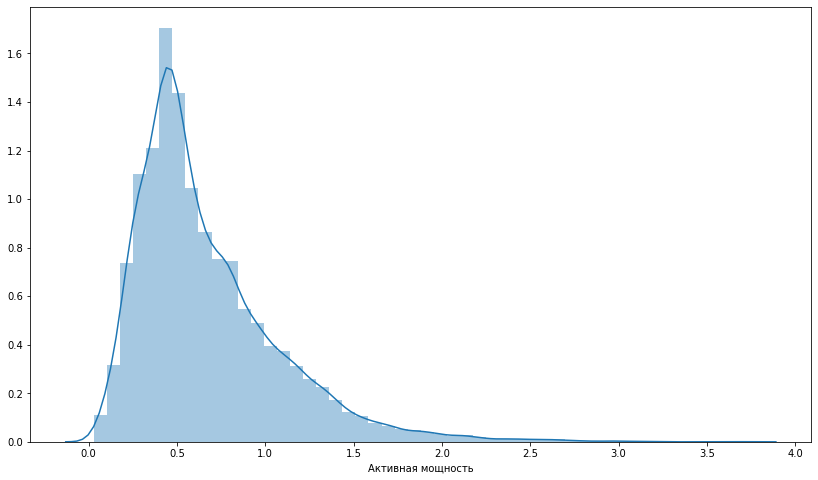

In [8]:
plt.figure(figsize=(14, 8))
sns.distplot(data_arc['Активная мощность'])
plt.show()

<b>Активная мощность</b> характеризует скорость необратимого превращения электрической энергии в другие виды энергии (тепловую и электромагнитную). Активная мощность может быть также выражена через силу тока, напряжение и активную составляющую сопротивления цепи

Активная мощность обозначается буквой P и измеряется в ваттах (Вт)

<b>P = U * I</b>

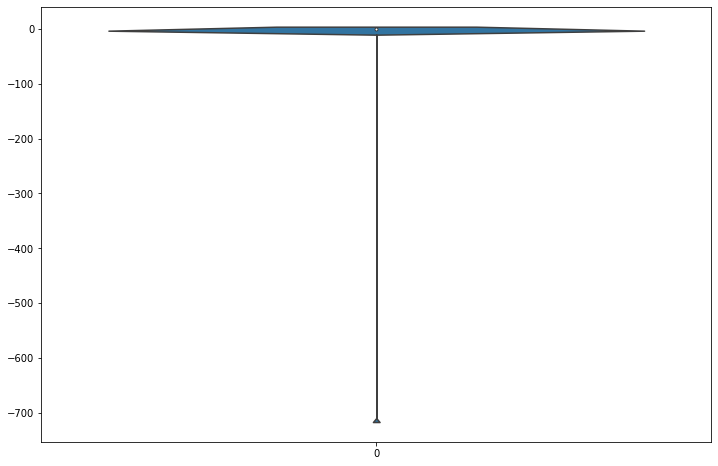

In [9]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=data_arc['Реактивная мощность'])
plt.show()

<b>Есть единичный выброс, который портит картину распределения. Его можно сразу удалить</b>

In [10]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

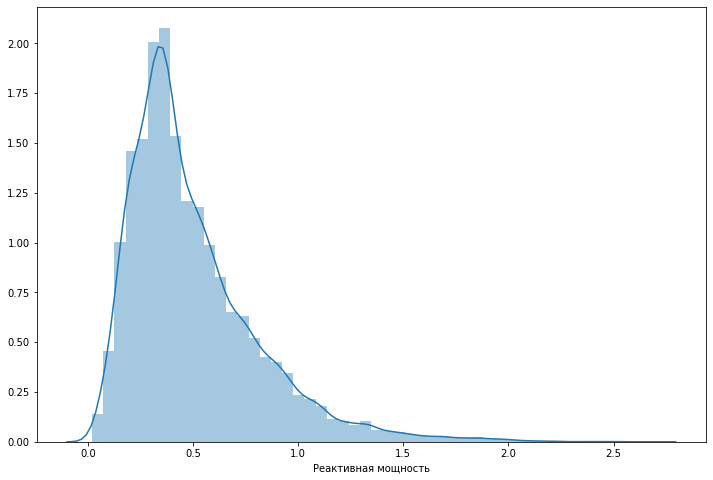

In [11]:
plt.figure(figsize=(12, 8))
sns.distplot(data_arc['Реактивная мощность'])
plt.show()

<b>Реактивная мощность</b> может быть как положительной величиной (если нагрузка имеет <b>активно-индуктивный характер</b>), так и отрицательной (если нагрузка имеет <b>активно-ёмкостный характер</b>)
Изменения тока в цепи отстаёт от соответствующих синусоидальных изменений напряжения. Такое поведение присуще любой т.н. <b>индуктивной нагрузке</b> (трансформаторы, электродвигатели, дроссели, электромагниты)

<b>Вред реактивной энергии</b> в электроэнергетике очевиден — она никак не используется, но шляется туда-сюда по проводам, дополнительно нагружая их. Кроме того, при таком «шлянии» эта энергия ещё и частично теряется, преобразуясь в активную энергию при нагреве проводов

Реактивная мощность обозначается буквой Q и измеряется в вольт-амперах реактивных (вар)

Для вычисления доли реактивной мощности применяется формула:

<b>Q = U * I * sin φ</b>

In [12]:
display(data_arc['Начало нагрева дугой'].min())
display(data_arc['Конец нагрева дугой'].max())

'2019-05-03 11:02:14'

'2019-09-01 04:36:08'

<b>Данные по нагреву дугой доступны за 5 месяцев</b>

In [13]:
check.full_info(data_bulk)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Количество дубликатов в записях: 0
Пропуски(nan):
Nan/null Bulk 1: 2877, доля: 91.9%
Nan/null Bulk 2: 3107, доля: 99.3%
Nan/null Bulk 3: 1831, доля: 58.5%
Nan/null Bulk 4: 2115, доля: 67.6%
Nan/null Bulk 5: 3052, доля: 97.5%
Nan/null Bulk 6: 2553, доля: 81.6%
Nan/null Bulk 7: 3104, доля: 99.2%
Nan/null Bulk 8: 3128, доля: 100.0%
Nan/null Bulk 9: 3110, доля: 99.4%
Nan/null Bulk 10: 2953, доля: 94.4%
Nan/null Bulk 11: 2952, доля: 94.3%
Nan/null Bulk 12: 679, доля: 21.7%
Nan/null Bulk 13: 3111, доля: 99.4%
Nan/null Bulk 14: 323, доля: 10.3%
Nan/null Bulk 15: 881, доля: 28.2%


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
check.full_info(data_bulk_time)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Количество дубликатов в записях: 0
Пропуски(nan):
Nan/null Bulk 1: 2877, доля: 91.9%
Nan/null Bulk 2: 3107, доля: 99.3%
Nan/null Bulk 3: 1831, доля: 58.5%
Nan/null Bulk 4: 2115, доля: 67.6%
Nan/null Bulk 5: 3052, доля: 97.5%
Nan/null Bulk 6: 2553, доля: 81.6%
Nan/null Bulk 7: 3104, доля: 99.2%
Nan/null Bulk 8: 3128, доля: 100.0%
Nan/null Bulk 9: 3110, доля: 99.4%
Nan/null Bulk 10: 2953, доля: 94.4%
Nan/null Bulk 11: 2952, доля: 94.3%
Nan/null Bulk 12: 679, доля: 21.7%
Nan/null Bulk 13: 3111, доля: 99.4%
Nan/null Bulk 14: 323, доля: 10.3%
Nan/null Bulk 15: 881, доля: 28.2%


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [15]:
check.full_info(data_gas)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Количество дубликатов в записях: 0
Пропуски(nan):


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


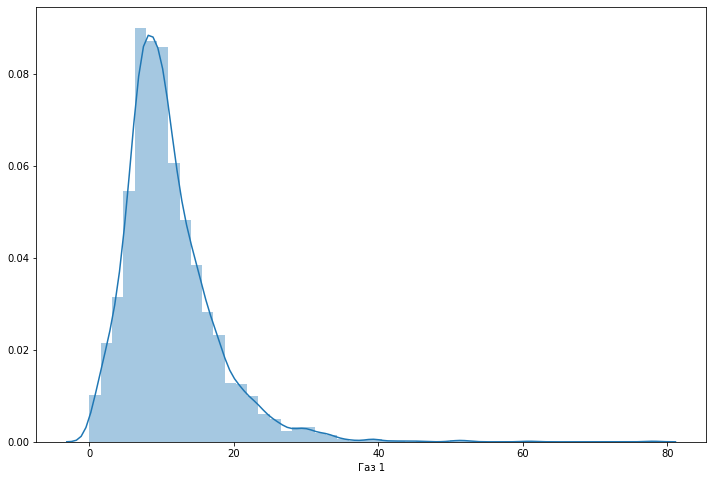

In [16]:
plt.figure(figsize=(12, 8))
sns.distplot(data_gas['Газ 1'])
plt.show()

<b>Объём/давление распределено нормально с положительным хвостом</b>

In [17]:
check.full_info(data_temp)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

Количество дубликатов в записях: 0
Пропуски(nan):
Nan/null Температура: 2901, доля: 18.2%


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


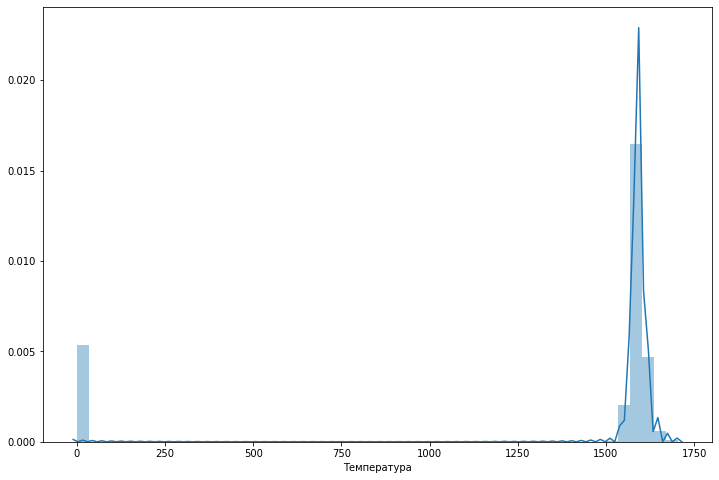

In [18]:
plt.figure(figsize=(12, 8))
sns.distplot(data_temp['Температура'].fillna(0))
plt.show()

In [19]:
data_temp[data_temp['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


<b>Температура распределена нормально, с отрицательным хвостом(несколько выбросов в данных, которые можно убрать)</b>

In [20]:
check.full_info(data_wire)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Количество дубликатов в записях: 0
Пропуски(nan):
Nan/null Wire 1: 26, доля: 0.8%
Nan/null Wire 2: 2002, доля: 65.0%
Nan/null Wire 3: 3018, доля: 98.0%
Nan/null Wire 4: 3067, доля: 99.5%
Nan/null Wire 5: 3080, доля: 100.0%
Nan/null Wire 6: 3008, доля: 97.6%
Nan/null Wire 7: 3070, доля: 99.6%
Nan/null Wire 8: 3062, доля: 99.4%
Nan/null Wire 9: 3052, доля: 99.1%


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Подача проволочных материалов предусмотрена не для всех партий, поэтому в этим местах пропуски</b>

In [21]:
check.full_info(data_wire_time)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Количество дубликатов в записях: 0
Пропуски(nan):
Nan/null Wire 1: 26, доля: 0.8%
Nan/null Wire 2: 2002, доля: 65.0%
Nan/null Wire 3: 3018, доля: 98.0%
Nan/null Wire 4: 3067, доля: 99.5%
Nan/null Wire 5: 3080, доля: 100.0%
Nan/null Wire 6: 3008, доля: 97.6%
Nan/null Wire 7: 3070, доля: 99.6%
Nan/null Wire 8: 3062, доля: 99.4%
Nan/null Wire 9: 3052, доля: 99.1%


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Время подачи проволочных материалов для партий, соответственно их отсутсвие - для данной партии не предусмотрено</b>

## Преобразование данных

In [22]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [23]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [24]:
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)
data_bulk_time.iloc[:, 1:16] = data_bulk_time.iloc[:, 1:16].apply(pd.to_datetime, errors='coerce')
data_wire_time.iloc[:, 1:10] = data_wire_time.iloc[:, 1:10].apply(pd.to_datetime, errors='coerce')

## Подготовка данных к обучению

<b>Объединим датасеты</b>

In [25]:
bulk_wire = data_bulk.merge(data_wire, how='inner', left_on='key', right_on='key')
display(len(bulk_wire))
display(bulk_wire.columns)

3025

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

<b>Сгенерируем новый признак для обучения - количество итераций</b>

In [26]:
# Исправил косяк с итерациями (считал количество замеров температуры, а не нагрева электродов)
temp_count = data_arc.groupby("key").agg({"Активная мощность":"count"}).reset_index()
temp_count.columns = ['key', 'Количество итераций']

<b>Функция для выделения крайних данных из каждой поставки</b>

In [27]:
def extract_row(data):
    train_row = pd.DataFrame(columns=data.columns)
    test_row = pd.DataFrame(columns=data.columns)
    unique_keys = data['key'].unique()
    for k in unique_keys:
        temp = data[data['key'] == k]
        if len(temp) > 1:
            train_row = train_row.append(temp.iloc[0])
            test_row = test_row.append(temp.iloc[-1])
    return train_row.reset_index(drop=True), test_row.reset_index(drop=True)

<b>Разделим температуру на начальную для тренировочного датасета и на тестовую конечную</b>

In [28]:
# Уберём предварительно выбросы
data_temp = data_temp[data_temp['Температура'] > 1400]

In [29]:
%%time
train_temp, test_temp = extract_row(data_temp)
train_temp.columns = ['key', 'Начало замера', 'Начальная температура']
test_temp.columns = ['key', 'Конец замера', 'Конечная температура']

CPU times: user 9.45 s, sys: 0 ns, total: 9.45 s
Wall time: 9.46 s


In [30]:
delta_temp = train_temp.merge(test_temp, how='inner', on='key')

In [31]:
delta_temp['measure_delta'] = (delta_temp['Конец замера'] - 
                               delta_temp['Начало замера']).astype('timedelta64[s]') / 60

In [32]:
delta_temp.drop(columns=['Начало замера', 'Конец замера'], axis=1, inplace=True)
delta_temp.head()

,key,Начальная температура,Конечная температура,measure_delta
0,1,1571.0,1613.0,14.350000
1,2,1581.0,1602.0,21.750000
2,3,1596.0,1599.0,21.666667
3,4,1601.0,1625.0,6.466667
4,5,1576.0,1602.0,12.700000


<b>Суммарное время нагрева электродугами</b>

In [33]:
data_arc['electrod_delta'] = (data_arc['Конец нагрева дугой'] - 
                              data_arc['Начало нагрева дугой']).astype('timedelta64[s]') / 60

In [34]:
group_arc = data_arc.groupby('key').agg({'electrod_delta':'sum'}).reset_index()
group_arc.head()

,key,electrod_delta
0,1,18.300000
1,2,13.516667
2,3,10.916667
3,4,12.350000
4,5,14.483333


<b>Выделим начальную активную и реактивную мощность в соответствии с данными о температуре</b>

In [35]:
%%time
start_arc, end_arc = extract_row(data_arc)

CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.5 s


In [36]:
start_arc.drop(columns=['Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность', 
                        'electrod_delta'], axis=1, inplace=True)
start_arc.head()

,key,Начало нагрева дугой
0,1,2019-05-03 11:02:14
1,2,2019-05-03 11:34:14
2,3,2019-05-03 12:06:54
3,4,2019-05-03 12:39:37
4,5,2019-05-03 13:11:13


In [37]:
end_arc.drop(columns=['Начало нагрева дугой', 'Активная мощность', 'Реактивная мощность', 
                        'electrod_delta'], axis=1, inplace=True)
end_arc.head()

,key,Конец нагрева дугой
0,1,2019-05-03 11:28:37
1,2,2019-05-03 11:53:18
2,3,2019-05-03 12:32:19
3,4,2019-05-03 12:57:50
4,5,2019-05-03 13:33:55


In [38]:
df = start_arc.merge(end_arc, how='inner')
display(len(df))
df.columns = ['key', 'Начало нагрева дугой', 'Конец нагрева дугой']
display(df.head())

3175

,key,Начало нагрева дугой,Конец нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55


In [39]:
df = df.merge(delta_temp, how='left')
display(len(df))
display(df.columns)
display(df.head())

3175

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Начальная температура', 'Конечная температура', 'measure_delta'],
      dtype='object')

,key,Начало нагрева дугой,Конец нагрева дугой,Начальная температура,Конечная температура,measure_delta
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1571.0,1613.0,14.350000
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,1581.0,1602.0,21.750000
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,1596.0,1599.0,21.666667
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,1601.0,1625.0,6.466667
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,1576.0,1602.0,12.700000


In [40]:
df = df.merge(group_arc, how='left')
display(len(df))
display(df.columns)
display(df.head())

3175

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Начальная температура', 'Конечная температура', 'measure_delta',
       'electrod_delta'],
      dtype='object')

,key,Начало нагрева дугой,Конец нагрева дугой,Начальная температура,Конечная температура,measure_delta,electrod_delta
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1571.0,1613.0,14.350000,18.300000
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,1581.0,1602.0,21.750000,13.516667
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,1596.0,1599.0,21.666667,10.916667
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,1601.0,1625.0,6.466667,12.350000
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,1576.0,1602.0,12.700000,14.483333


In [41]:
df = df.merge(data_gas, how='left')
display(len(df))
display(df.columns)
display(df.head())

3175

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Начальная температура', 'Конечная температура', 'measure_delta',
       'electrod_delta', 'Газ 1'],
      dtype='object')

,key,Начало нагрева дугой,Конец нагрева дугой,Начальная температура,Конечная температура,measure_delta,electrod_delta,Газ 1
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1571.0,1613.0,14.350000,18.300000,29.749986
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,1581.0,1602.0,21.750000,13.516667,12.555561
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,1596.0,1599.0,21.666667,10.916667,28.554793
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,1601.0,1625.0,6.466667,12.350000,18.841219
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,1576.0,1602.0,12.700000,14.483333,5.413692


<b>Добавим новый признак - количество итераций нагрева, дельта нагрева и полную мощность</b>

In [42]:
df = df.merge(temp_count, how='left')
display(len(df))
display(df.columns)

3175

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Начальная температура', 'Конечная температура', 'measure_delta',
       'electrod_delta', 'Газ 1', 'Количество итераций'],
      dtype='object')

In [43]:
mean_power = data_arc.groupby('key').agg({'Активная мощность':'mean', 
                                          'Реактивная мощность':'mean'}).reset_index()

In [44]:
mean_power['Полная мощность'] = np.sqrt(mean_power['Активная мощность'] ** 2 + 
                                        mean_power['Реактивная мощность'] ** 2)

In [45]:
df = df.merge(mean_power, how='left')
display(len(df))
display(df.columns)
df.head()

3175

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Начальная температура', 'Конечная температура', 'measure_delta',
       'electrod_delta', 'Газ 1', 'Количество итераций', 'Активная мощность',
       'Реактивная мощность', 'Полная мощность'],
      dtype='object')

,key,Начало нагрева дугой,Конец нагрева дугой,Начальная температура,Конечная температура,measure_delta,electrod_delta,Газ 1,Количество итераций,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,1571.0,1613.0,14.350000,18.300000,29.749986,5,0.975629,0.636648,1.164978
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,1581.0,1602.0,21.750000,13.516667,12.555561,4,0.763150,0.499528,0.912099
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,1596.0,1599.0,21.666667,10.916667,28.554793,5,0.505176,0.319815,0.597900
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,1601.0,1625.0,6.466667,12.350000,18.841219,4,0.802313,0.515074,0.953419
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,1576.0,1602.0,12.700000,14.483333,5.413692,4,0.836793,0.563161,1.008649


<b>Соединим датасет с добавками</b>

In [46]:
df = df.merge(bulk_wire, how='left', on='key')
display(len(df))
display(df.columns)

3175

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Начальная температура', 'Конечная температура', 'measure_delta',
       'electrod_delta', 'Газ 1', 'Количество итераций', 'Активная мощность',
       'Реактивная мощность', 'Полная мощность', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9'],
      dtype='object')

In [47]:
df.fillna(0, inplace=True)

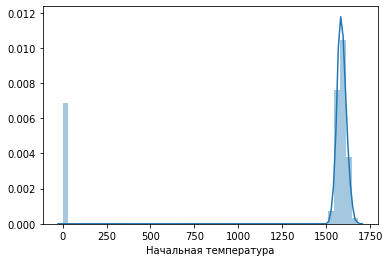

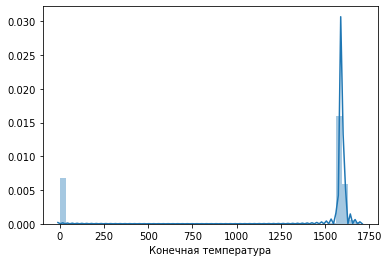

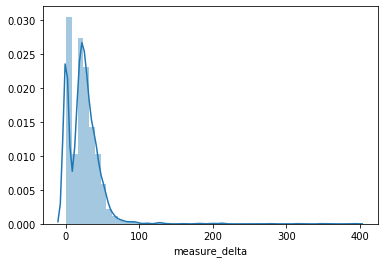

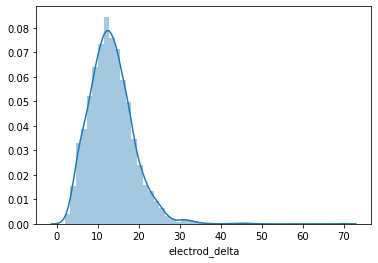

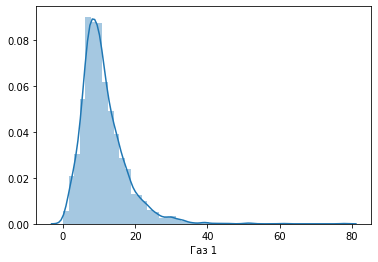

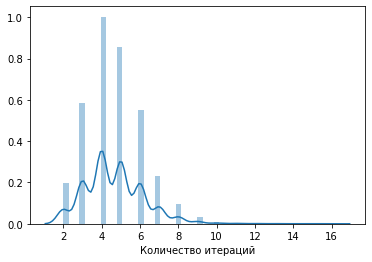

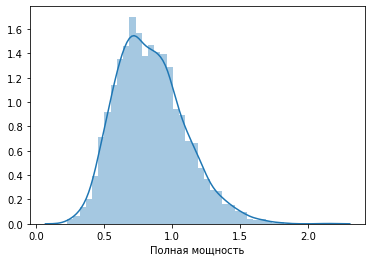

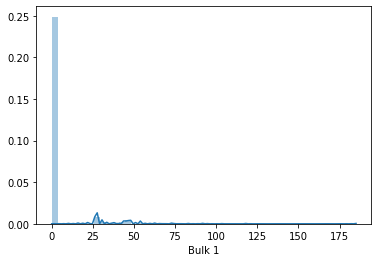

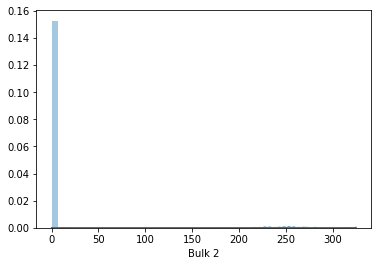

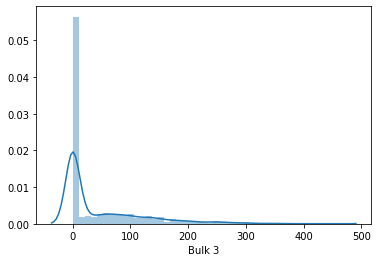

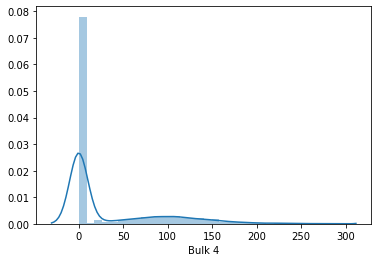

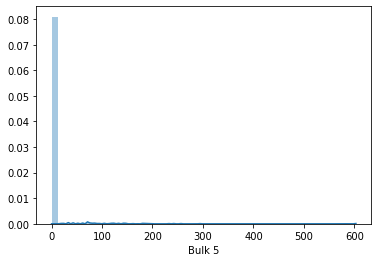

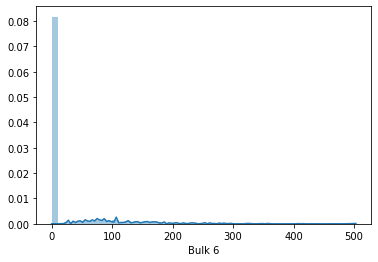

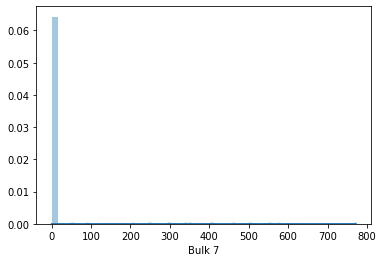

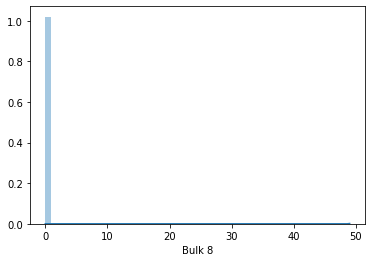

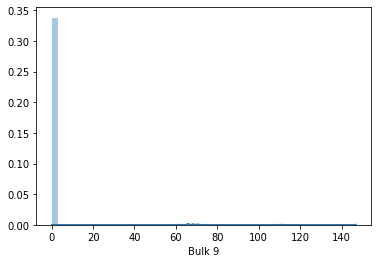

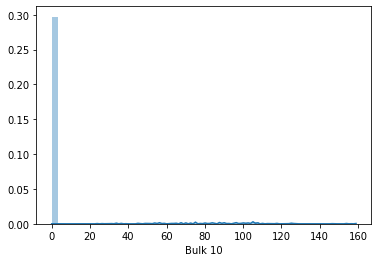

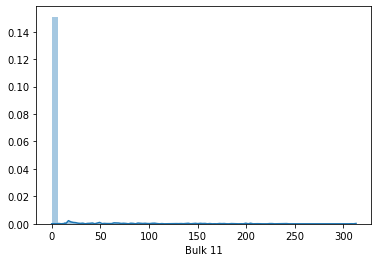

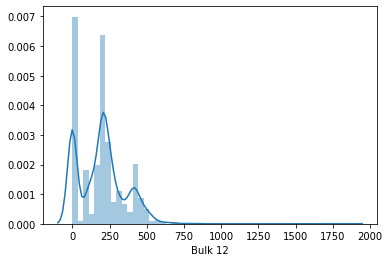

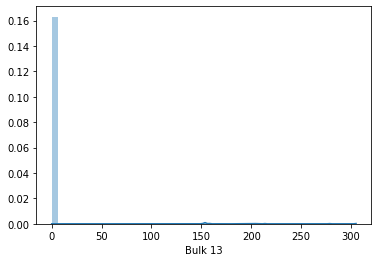

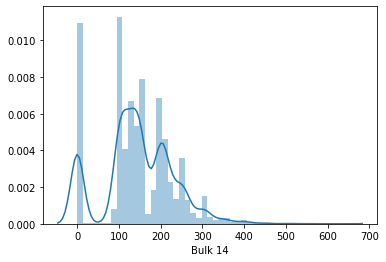

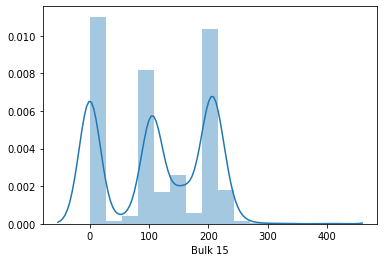

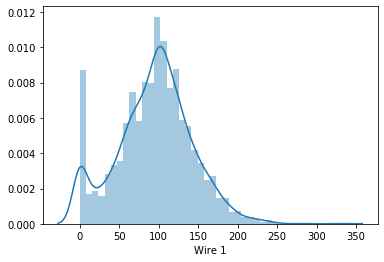

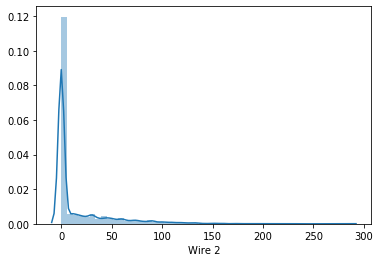

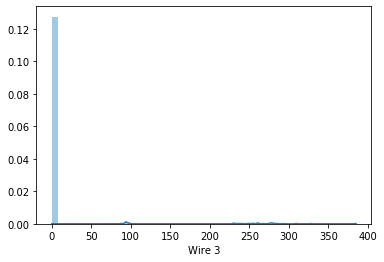

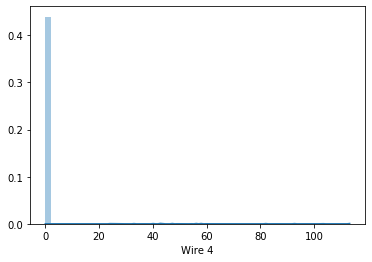

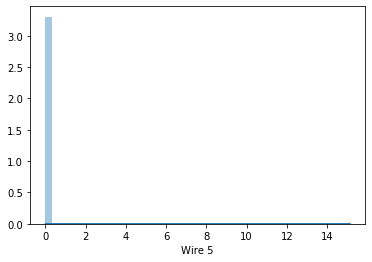

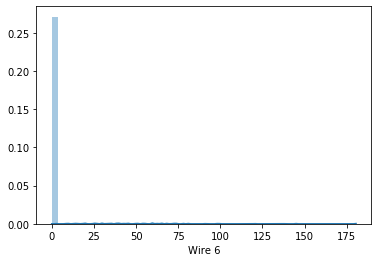

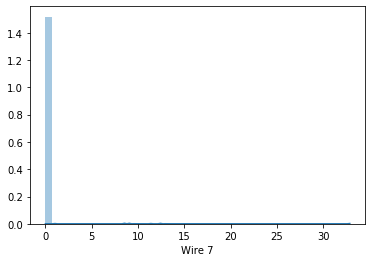

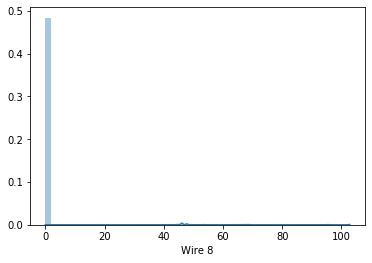

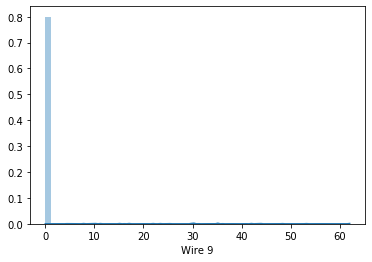

In [48]:
for col in df[['Начальная температура', 'Конечная температура', 'measure_delta',
       'electrod_delta', 'Газ 1', 'Количество итераций',
       'Полная мощность', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']]:
    sns.distplot(df[col])
    plt.show()

<b>Удалим столбцы с большим количеством нулей после fillna данных</b>

In [49]:
df.drop(columns=['Wire 9', 'Wire 8', 'Wire 7', 'Wire 6', 
                 'Wire 5', 'Wire 4', 'Wire 3', 'Wire 2', 'Bulk 13', 
                 'Bulk 11', 'Bulk 10', 'Bulk 9', 'Bulk 8', 'Bulk 7', 'Bulk 6', 'Bulk 5', 'Bulk 1',
                'Bulk 1', 'Bulk 2', 'Начало нагрева дугой', 'Конец нагрева дугой'], axis=1, inplace=True)

<b>Выбросим нулевые значения в температурах</b>

In [50]:
df = df[(df['Начальная температура'] > 0) & (df['Конечная температура'] > 0)]

<b>Построим матрицу корреляции</b>

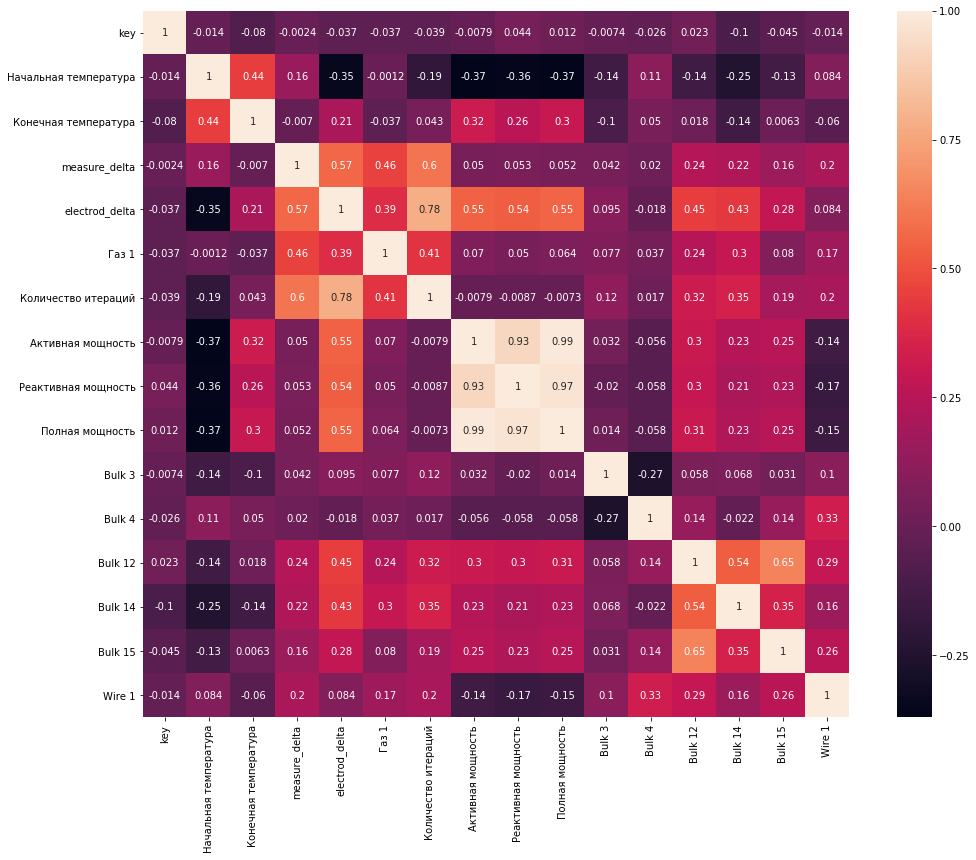

In [51]:
f = plt.figure(figsize=(17, 13))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

<b>Также поищем возможную отрицательную корреляцию</b>

In [52]:
train_corr = df.corr()
corr_pairs = train_corr.unstack()
temp_corr = corr_pairs.sort_values(ascending=False)
temp_corr = temp_corr[(abs(temp_corr) < 1) & (abs(temp_corr) > 0.9)]
display(temp_corr.head())
display(len(temp_corr))

Полная мощность      Активная мощность      0.989662
Активная мощность    Полная мощность        0.989662
Реактивная мощность  Полная мощность        0.971556
Полная мощность      Реактивная мощность    0.971556
Реактивная мощность  Активная мощность      0.927812
dtype: float64

6

<b>Здесь мы наблюдаем корреляцию между тремя признаками, поэтому будем использовать 1-2 из них</b>

In [53]:
df = df.drop(columns=['key'], axis=1)

<b>Наблюдается корреляция между активной и реактивной мощностью, а также подачей проволки и сыпучих материалов</b>

<b>Взглянем на распределения темератур на тренировочном и тестовом датасете</b>

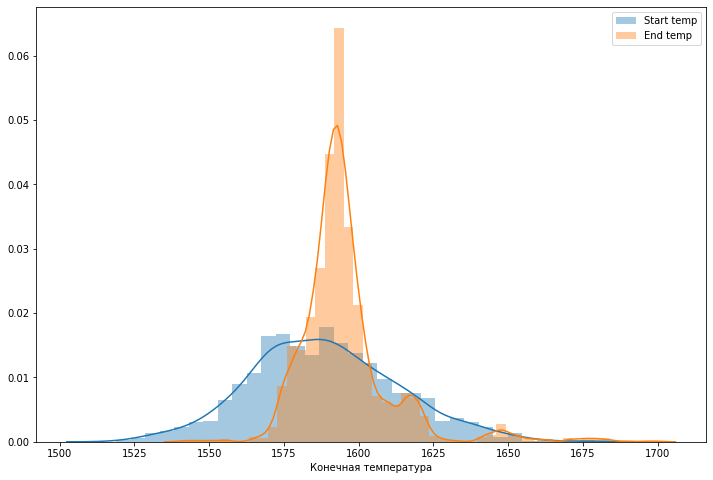

In [54]:
plt.figure(figsize=(12, 8))
sns.distplot(df['Начальная температура'], label='Start temp')
sns.distplot(df['Конечная температура'], label='End temp')
plt.legend()
plt.show()

<b>Здесь есть небольшие различия в температуре, а конечная температура имеет пару горбов вправо и логичные высокие показатели нагрева</b>

### Разобьём данные на выборки

<b>Выберу только те признаки, в которых больше значений, чем заполненных нулей</b>

In [55]:
df.columns

Index(['Начальная температура', 'Конечная температура', 'measure_delta',
       'electrod_delta', 'Газ 1', 'Количество итераций', 'Активная мощность',
       'Реактивная мощность', 'Полная мощность', 'Bulk 3', 'Bulk 4', 'Bulk 12',
       'Bulk 14', 'Bulk 15', 'Wire 1'],
      dtype='object')

In [56]:
df_general = df.copy()

In [57]:
df_general = df_general.drop(columns=['Количество итераций', 'Реактивная мощность', 
                                      'Полная мощность', 'Bulk 3'], axis=1)

In [58]:
df_train, df_test = train_test_split(df_general, test_size=0.20, random_state=123456)
display(len(df_train), len(df_test))

1954

489

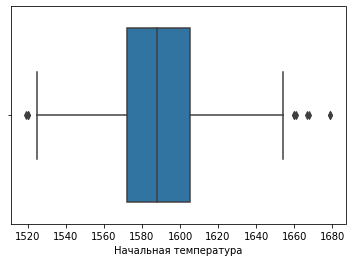

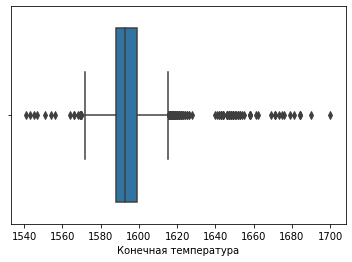

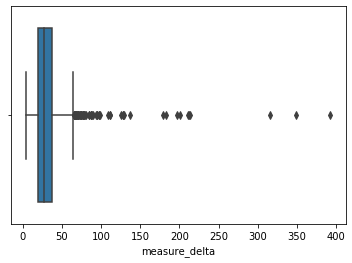

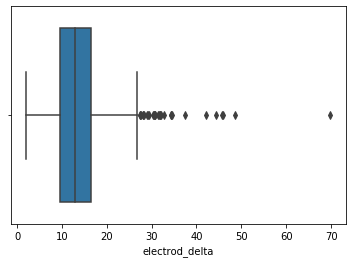

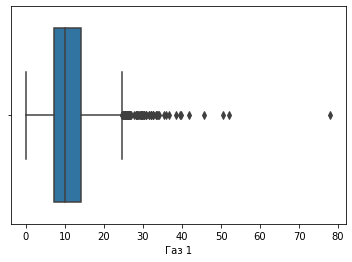

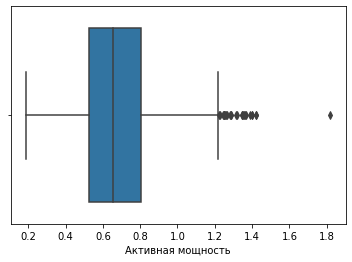

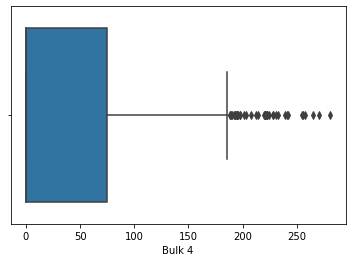

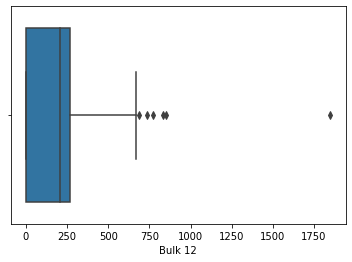

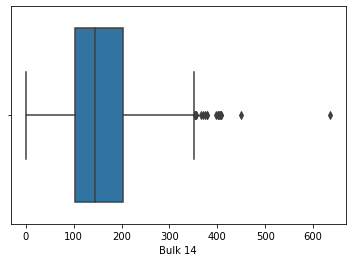

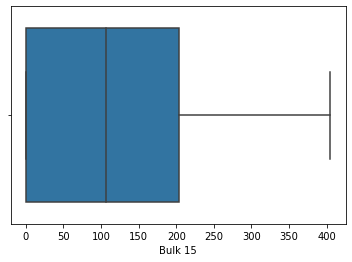

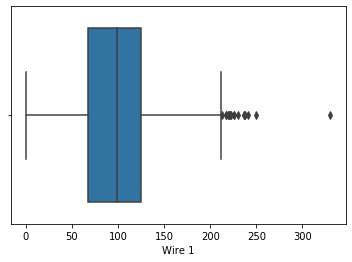

In [59]:
for col in df_train:
    sns.boxplot(df_train[col])
    plt.show()

<b>Почистим тренировочную выборку</b>

In [60]:
df_train = df_train[(df_train['Конечная температура'] <= 1640) & (df_train['Конечная температура'] >= 1350)]
len(df_train)

1890

In [142]:
len(df_test)

489

In [61]:
X_train = df_train.drop(columns='Конечная температура', axis=1)
y_train = df_train['Конечная температура']

In [62]:
X_test = df_train.drop(columns='Конечная температура', axis=1)
y_test = df_train['Конечная температура']

In [63]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_features = pd.DataFrame(scaler.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)

In [64]:
scaler.fit(X_test)
scaled_test_features = pd.DataFrame(scaler.transform(X_test), index=X_test.index, 
                                    columns=X_test.columns)

## Построение и обучение моделей

<b>Сформируем таблицу значений кросс-валидации</b>

In [65]:
# Сформируем таблицу значений кросс-валидации
df_model = pd.DataFrame({
    'Model':['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'RidgeCV', 
             'KNeighborsRegressor', 'LGBMRegressor', 'SGDRegressor', 'XGBRegressor', 
             'CatBoostRegressor', 'DummyRegressor', 'Нейронная сеть'],
    'MAE(cross_val_score)':[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, None],
    'MAE(hyperparameters)':[None, None, None, None, None, None, None, None, None, 
                                 None, None],
    'MAE(Test)':[None, None, None, None, None, None, None, None, None, 
                                 None, None]
})
df_model['MAE(cross_val_score)'] = df_model['MAE(cross_val_score)'].astype('float16')
df_model['MAE(hyperparameters)'] = df_model['MAE(hyperparameters)'].astype('float16')
df_model['MAE(Test)'] = df_model['MAE(Test)'].astype('float16')

<b>LinearRegression</b>

In [66]:
%%time
np.random.seed(111)
reg = LinearRegression(n_jobs=1)
results = cross_validate(reg, scaled_features, y_train, cv=5, 
                         scoring='neg_mean_absolute_error', return_train_score=True)
display(results)
display(abs(results['test_score'].mean()))
df_model.loc[0, 'MAE(cross_val_score)'] = abs(results['test_score'].mean())

{'fit_time': array([0.00243354, 0.00298882, 0.00364828, 0.0922749 , 0.00319862]),
 'score_time': array([0.00098419, 0.00124502, 0.00141001, 0.00220942, 0.00132203]),
 'test_score': array([-6.27846554, -5.6621042 , -5.58997225, -6.377521  , -6.30898186]),
 'train_score': array([-5.92343086, -6.12499008, -6.10313281, -5.90457881, -5.92976981])}

6.043408971009967

CPU times: user 156 ms, sys: 171 ms, total: 327 ms
Wall time: 286 ms


<b>DecisionTreeRegressor</b>

In [67]:
%%time
des = DecisionTreeRegressor(random_state=222)
des_results = cross_validate(des, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', 
                             return_train_score=True)
display(des_results)
display(abs(des_results['test_score'].mean()))
df_model.loc[1, 'MAE(cross_val_score)'] = abs(des_results['test_score'].mean())

{'fit_time': array([0.02378654, 0.01351833, 0.05702043, 0.01226926, 0.01166129]),
 'score_time': array([0.00157428, 0.00085092, 0.00124836, 0.00079656, 0.00075269]),
 'test_score': array([-8.77777778, -8.45767196, -8.65608466, -8.74338624, -8.57936508]),
 'train_score': array([-0., -0., -0., -0., -0.])}

8.642857142857142

CPU times: user 98.1 ms, sys: 28.1 ms, total: 126 ms
Wall time: 136 ms


<b>RandomForestRegressor</b>

In [68]:
### Много времени, поэтому закомментил
forest_model = RandomForestRegressor(random_state=223, n_estimators=100)
forest_results = cross_validate(forest_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', 
                                 n_jobs=-1, return_train_score=True)
display(forest_results)
display(abs(forest_results['test_score'].mean()))
df_model.loc[2, 'MAE(cross_val_score)'] = abs(forest_results['test_score'].mean())

{'fit_time': array([0.72143388, 0.71859717, 0.77691531, 0.72826195, 0.73436213]),
 'score_time': array([0.01079607, 0.01175213, 0.01150203, 0.01138353, 0.01097918]),
 'test_score': array([-6.37965608, -5.81626984, -5.69997354, -6.12328042, -6.13230159]),
 'train_score': array([-2.21162698, -2.25842593, -2.27852513, -2.26406085, -2.26058862])}

6.0302962962962985

<b>RidgeCV</b>

In [69]:
%%time
np.random.seed(444)
ridge_model = RidgeCV()
ridge_results = cross_validate(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',
                              return_train_score=True)
display(ridge_results)
display(abs(ridge_results['test_score'].mean()))
df_model.loc[3, 'MAE(cross_val_score)'] = abs(ridge_results['test_score'].mean())

{'fit_time': array([0.0912776 , 0.00380611, 0.00433087, 0.09229803, 0.09457588]),
 'score_time': array([0.00168371, 0.0012598 , 0.00132585, 0.00311565, 0.0017364 ]),
 'test_score': array([-6.27863748, -5.66193588, -5.58846744, -6.37685826, -6.30955604]),
 'train_score': array([-5.92326255, -6.1247168 , -6.10140224, -5.90448459, -5.92883421])}

6.0430910221875465

CPU times: user 214 ms, sys: 244 ms, total: 457 ms
Wall time: 401 ms


<b>KNeighborsRegressor</b>

In [70]:
%%time
np.random.seed(445)
knn_model = KNeighborsRegressor()
knne_results = cross_validate(knn_model, scaled_features, y_train, cv=5, scoring='neg_mean_absolute_error',
                              return_train_score=True)
display(knne_results)
display(abs(knne_results['test_score'].mean()))
df_model.loc[4, 'MAE(cross_val_score)'] = abs(knne_results['test_score'].mean())

{'fit_time': array([0.00405526, 0.00193   , 0.00209236, 0.00194192, 0.00205421]),
 'score_time': array([0.09006143, 0.00853014, 0.00883007, 0.00911021, 0.01160908]),
 'test_score': array([-7.15978836, -6.61904762, -6.47936508, -6.96455026, -6.55608466]),
 'train_score': array([-5.39298942, -5.50978836, -5.64272487, -5.55912698, -5.45793651])}

6.7557671957671985

CPU times: user 234 ms, sys: 32 ms, total: 266 ms
Wall time: 311 ms


<b>LGBMRegressor</b>

In [71]:
%%time
lgb_model = LGBMRegressor(random_state=6665)
lgb_results = cross_validate(lgb_model, scaled_features, y_train, cv=5, n_jobs=-1,
                              verbose=1, scoring='neg_mean_absolute_error',
                              return_train_score=True)
display(lgb_results)
display(abs(lgb_results['test_score'].mean()))
df_model.loc[5, 'MAE(cross_val_score)'] = abs(lgb_results['test_score'].mean())

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


{'fit_time': array([1.17624307, 0.90122652, 0.68938971, 0.69552612, 0.69603896]),
 'score_time': array([0.01097608, 0.00445843, 0.00414062, 0.09279895, 0.00435019]),
 'test_score': array([-6.24799222, -5.905104  , -5.5803735 , -6.06599582, -6.11128188]),
 'train_score': array([-2.50629944, -2.46989391, -2.52807977, -2.55495682, -2.52936739])}

5.982149483211751

CPU times: user 4.38 s, sys: 68.2 ms, total: 4.45 s
Wall time: 4.48 s


<b>SGDRegressor</b>

In [72]:
%%time
sgd_model = SGDRegressor(random_state=6666)
sgd_results = cross_validate(sgd_model, X_train, y_train, cv=5, n_jobs=-1,
                              verbose=1, scoring='neg_mean_absolute_error',
                              return_train_score=True)
display(sgd_results)
display(abs(sgd_results['test_score'].mean()))
df_model.loc[6, 'MAE(cross_val_score)'] = abs(sgd_results['test_score'].mean())

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


{'fit_time': array([0.00634956, 0.08224487, 0.10128665, 0.00875521, 0.01033759]),
 'score_time': array([0.00075459, 0.00179887, 0.09009457, 0.00129986, 0.00080252]),
 'test_score': array([-5.41452350e+14, -9.21727253e+14, -8.31564996e+14, -1.30584453e+15,
        -2.47922857e+14]),
 'train_score': array([-5.38351340e+14, -9.26093195e+14, -8.32844571e+14, -1.33059420e+15,
        -2.45418970e+14])}

769702397967109.0

CPU times: user 266 ms, sys: 229 ms, total: 495 ms
Wall time: 494 ms


<b>XGBRegressor</b>

In [73]:
%%time
xgb_model = XGBRegressor(random_state=7777)
xgb_results = cross_validate(xgb_model, X_train, y_train, cv=5, n_jobs=-1,
                              verbose=1, scoring='neg_mean_absolute_error',
                              return_train_score=True)
display(xgb_results)
display(abs(xgb_results['test_score'].mean()))
df_model.loc[7, 'MAE(cross_val_score)'] = abs(xgb_results['test_score'].mean())

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:45:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


{'fit_time': array([0.25384712, 0.0885973 , 0.0847764 , 0.08803248, 0.0902977 ]),
 'score_time': array([0.00203538, 0.00210881, 0.00203466, 0.00205541, 0.00208116]),
 'test_score': array([-6.46163472, -5.72772669, -5.73427909, -6.19521626, -6.15738416]),
 'train_score': array([-4.8276037 , -5.00472054, -4.90722777, -4.85282543, -4.90157863])}

6.05524818380043

CPU times: user 493 ms, sys: 48.6 ms, total: 542 ms
Wall time: 644 ms


<b>CatBoostRegressor</b>

In [74]:
%%time
cat_model = CatBoostRegressor(random_state=8888)
cat_results = cross_validate(cat_model, scaled_features, y_train, cv=5, n_jobs=-1,
                              verbose=1, scoring='neg_mean_absolute_error',
                              return_train_score=True)
display(cat_results)
display(abs(cat_results['test_score'].mean()))
df_model.loc[8, 'MAE(cross_val_score)'] = abs(cat_results['test_score'].mean())

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 10.7701726	total: 49.1ms	remaining: 49s
1:	learn: 10.6908238	total: 50.4ms	remaining: 25.1s
2:	learn: 10.6098321	total: 51.5ms	remaining: 17.1s
3:	learn: 10.5362287	total: 52.7ms	remaining: 13.1s
4:	learn: 10.4645222	total: 53.7ms	remaining: 10.7s
5:	learn: 10.4013984	total: 54.8ms	remaining: 9.08s
6:	learn: 10.3277479	total: 55.9ms	remaining: 7.93s
7:	learn: 10.2604854	total: 57ms	remaining: 7.06s
8:	learn: 10.2096933	total: 58ms	remaining: 6.39s
9:	learn: 10.1505812	total: 59.1ms	remaining: 5.85s
10:	learn: 10.0766116	total: 143ms	remaining: 12.8s
11:	learn: 10.0140421	total: 144ms	remaining: 11.9s
12:	learn: 9.9522586	total: 145ms	remaining: 11s
13:	learn: 9.8961639	total: 146ms	remaining: 10.3s
14:	learn: 9.8386262	total: 148ms	remaining: 9.69s
15:	learn: 9.7848113	total: 149ms	remaining: 9.15s
16:	learn: 9.7311898	total: 150ms	remaining: 8.67s
17:	learn: 9.6880950	total: 151ms	remaining: 8.24s
18:	learn: 9.6368984	total: 153ms	remaining: 7.9s
19:	learn: 9.5854689	total: 

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


{'fit_time': array([13.18225193, 14.36161685, 12.63225985, 12.69321775, 12.65336394]),
 'score_time': array([0.00269032, 0.01156616, 0.00311828, 0.00283861, 0.00571132]),
 'test_score': array([-6.15741283, -5.5889237 , -5.42280224, -5.78370108, -5.87637491]),
 'train_score': array([-2.94968856, -3.06673788, -3.08991698, -2.99172801, -3.06098179])}

5.765842949278843

CPU times: user 52.5 s, sys: 5.63 s, total: 58.1 s
Wall time: 1min 5s


<b>DummyRegressor</b>

In [75]:
%%time
np.random.seed(666)
parameters = {
    'strategy':['quantile', 'median', 'mean', 'constant'], 'quantile':[0.0, 1.0], 
    'constant':[np.mean(y_train) * len(X_train)]}
dummy_model = DummyRegressor()
dummy_clf = GridSearchCV(dummy_model, parameters, scoring='neg_mean_absolute_error', cv=5)
dummy_clf.fit(X_train, y_train)
display(dummy_clf.best_params_)
display(abs(dummy_clf.best_score_))
y_pred = dummy_clf.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
df_model.loc[9, 'MAE(cross_val_score)'] = abs(dummy_clf.best_score_)

{'constant': 3011360.0, 'quantile': 0.0, 'strategy': 'median'}

7.931216931216931

7.923809523809524
CPU times: user 68.1 ms, sys: 8.22 ms, total: 76.3 ms
Wall time: 74 ms


<b>Нейронная сеть:</b>

In [76]:
num_neurons = 12
myRMSProp = keras.optimizers.RMSprop(lr=0.0001, momentum=0.0)
#myAdam = keras.optimizers.Adam(lr=0.0001)
#mySGD = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)

In [77]:
def baseline_model():
    global num_neurons, myRMSProp
    model = Sequential()
    model.add(Dense(num_neurons, activation = 'linear', input_shape=(X_train.shape[1],)))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(optimizer = myRMSProp, loss = 'mse', metrics = ['mae'])
    return model

<b>Сделаем нормализацию для тренировочной и тестовой выборки, а также для тагетов</b>

In [78]:
def norm(x):
    return (x - x.mean()) / x.std(axis=0)

def y_norm(y):
    y_min = y.min()
    y_max = y.max()
    return ((y - y_min) / y_max), y_min, y_max

In [79]:
model = baseline_model()

In [129]:
n_train = norm(X_train)
n_test = norm(X_test)
y_min = y_train.min()
y_max = y_train.max() - y_min
n_y_train, y_min, y_max = y_norm(y_train)
n_y_test, _, _ = y_norm(y_test)

<b>Обучим сеть</b>

In [130]:
%%time
history = model.fit(n_train, 
                    n_y_train, 
                    epochs=100,
                    batch_size=24,
                    validation_split=0.1, 
                    verbose=2)

Train on 1701 samples, validate on 189 samples
Epoch 1/100
1701/1701 - 0s - loss: 2.0254e-05 - mae: 0.0035 - val_loss: 2.2683e-05 - val_mae: 0.0037
Epoch 2/100
1701/1701 - 0s - loss: 2.0246e-05 - mae: 0.0035 - val_loss: 2.4454e-05 - val_mae: 0.0039
Epoch 3/100
1701/1701 - 0s - loss: 2.0283e-05 - mae: 0.0035 - val_loss: 2.3490e-05 - val_mae: 0.0038
Epoch 4/100
1701/1701 - 0s - loss: 2.0188e-05 - mae: 0.0035 - val_loss: 2.5213e-05 - val_mae: 0.0039
Epoch 5/100
1701/1701 - 0s - loss: 2.0220e-05 - mae: 0.0035 - val_loss: 2.4443e-05 - val_mae: 0.0038
Epoch 6/100
1701/1701 - 0s - loss: 2.0164e-05 - mae: 0.0035 - val_loss: 2.2997e-05 - val_mae: 0.0037
Epoch 7/100
1701/1701 - 0s - loss: 2.0248e-05 - mae: 0.0035 - val_loss: 2.3578e-05 - val_mae: 0.0038
Epoch 8/100
1701/1701 - 0s - loss: 2.0224e-05 - mae: 0.0035 - val_loss: 2.3444e-05 - val_mae: 0.0038
Epoch 9/100
1701/1701 - 0s - loss: 2.0272e-05 - mae: 0.0035 - val_loss: 2.3091e-05 - val_mae: 0.0037
Epoch 10/100
1701/1701 - 0s - loss: 2.0240e-

<b>Делаю предсказания на тесте и возвращаю исходную размерность</b>

In [131]:
df_model.loc[10, 'MAE(cross_val_score)'] = 0.0035 * y_max
df_model.loc[10, 'MAE(hyperparameters)'] = 0.0038 * y_max

In [132]:
neuron_pred = model.predict(n_test).flatten()
neuron_pred = neuron_pred * y_max + y_min
n_y_test = n_y_test * y_max + y_min

In [133]:
print(mean_absolute_error(n_y_test, neuron_pred))
df_model.loc[10, 'MAE(Test)'] = mean_absolute_error(n_y_test, neuron_pred)

5.747541025958995


<b>Взглянем на разброс предсказанных точек и правильных</b>

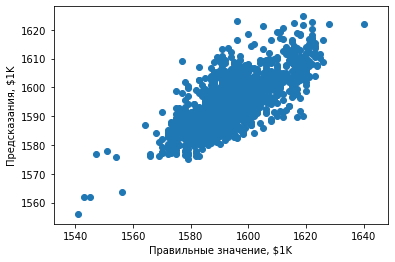

In [84]:
plt.scatter(n_y_test, neuron_pred) 
plt.xlabel('Правильные значение, $1K')
plt.ylabel('Предсказания, $1K')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

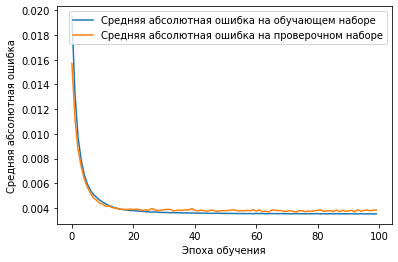

In [85]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

<b>Таблица производительности и качества моделей(cross_val_score)</b>

In [140]:
display(df_model.sort_values('MAE(cross_val_score)'))

,Model,MAE(cross_val_score),MAE(hyperparameters),MAE(Test)
10,Нейронная сеть,5.738281,6.230469,5.746094
8,CatBoostRegressor,5.765625,NaN,4.355469
5,LGBMRegressor,5.980469,5.859375,4.664062
2,RandomForestRegressor,6.031250,6.839844,6.546875
0,LinearRegression,6.042969,6.089844,6.000000
3,RidgeCV,6.042969,NaN,NaN
7,XGBRegressor,6.054688,5.851562,4.214844
4,KNeighborsRegressor,6.753906,NaN,NaN
9,DummyRegressor,7.929688,NaN,NaN
1,DecisionTreeRegressor,8.640625,NaN,NaN


<b>Нейронку сложно интерпретировать, а для предприятий важна прозрачность модели, поэтому её выкину из финалистов.</b>

<b>В итоге наши полуфиналисты:</b>
* Нейронная сеть	5.73
* CatBoostRegressor	5.76
* LGBMRegressor	5.98
* XGBRegressor	6.05
* RandomForestRegressor	6.03

## Выбор предфинальных моделей(подбор гиперпараметров)

<b>Добавим функцию, для отрисовки важности признаков</b>

In [87]:
def plot_importances(model, color):
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color=color, align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.grid()
    plt.show()

<b>Отрисовка гиперпараметров</b>

In [143]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.grid()
    ax.legend(title=param_z)
    return fig

<b>Подбор гиперпараметров для LinearRegression</b>

In [137]:
#np.random.seed(212)
#test_model = LinearRegression()
#test_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#test_fold = KFold(n_splits=5, shuffle=True)
#test_grid = GridSearchCV(test_model, test_parameters, cv=test_fold, n_jobs=-1, 
#                         verbose=1, scoring='neg_mean_absolute_error')
#test_grid.fit(scaled_features, y_train)
#display(test_grid.best_score_)
#display(test_grid.best_params_)

In [136]:
df_model.loc[0, 'MAE(hyperparameters)'] = 6.09

<b>LinearRegression и метрика с гиперпараметрами</b>

6.090604005266123

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [139]:
np.random.seed(213)
lr_final = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
lr_final.fit(scaled_features, y_train)
lr_pred = lr_final.predict(scaled_test_features)
lr_metrik = mean_absolute_error(y_test, lr_pred)
display(lr_metrik)
df_model.loc[0, 'MAE(Test)'] = lr_metrik
coefficients = pd.concat([pd.DataFrame(scaled_features.columns),pd.DataFrame(np.transpose(lr_final.coef_))], axis = 1)
display(coefficients, lr_final.intercept_)

6.000658089491029

,0,0
0,Начальная температура,8.391995
1,measure_delta,-5.758765
2,electrod_delta,8.463840
3,Газ 1,-0.853622
4,Активная мощность,2.580570
5,Bulk 4,0.305939
6,Bulk 12,-0.645457
7,Bulk 14,-0.823964
8,Bulk 15,1.212583
9,Wire 1,1.645672


1593.3121693121693

<b>Подбор гиперпараметров для LGBMRegressor</b>

In [88]:
### Оооочень много времени, поэтому закомментил
#lgbm_parameters = {
#    'learning_rate': [0.1, 0.03, 0.003],
#    'max_depth': [1, 2, 3],
#    'n_estimators': [50, 100, 200, 500, 750, 1000],
#}
#fold = KFold(n_splits=5, shuffle=True)
#lgbm_mod = LGBMRegressor(random_state=669)
#lgbm_clf = GridSearchCV(lgbm_mod, lgbm_parameters, cv=fold, scoring='neg_mean_absolute_error', 
#                        n_jobs=-1, verbose=1)
#lgbm_clf.fit(X_train, y_train)
#display(abs(lgbm_clf.best_score_))
#display(lgbm_clf.best_params_)

<b>LGBMRegressor и метрика с гиперпараметрами</b>

In [89]:
df_model.loc[5, 'MAE(hyperparameters)'] = 5.86

5.862308439807312

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}

In [90]:
%%time
lgbm_final = LGBMRegressor(learning_rate=0.03, max_depth=3, n_estimators=500, random_state=19999)
lgbm_final.fit(X_train, y_train)
lgbm_pred = lgbm_final.predict(X_test)
lgbm_final_metric = mean_absolute_error(y_test, lgbm_pred)
display(lgbm_final_metric)
df_model.loc[5, 'MAE(Test)'] = lgbm_final_metric

4.66531409245652

CPU times: user 141 ms, sys: 12.4 ms, total: 154 ms
Wall time: 153 ms


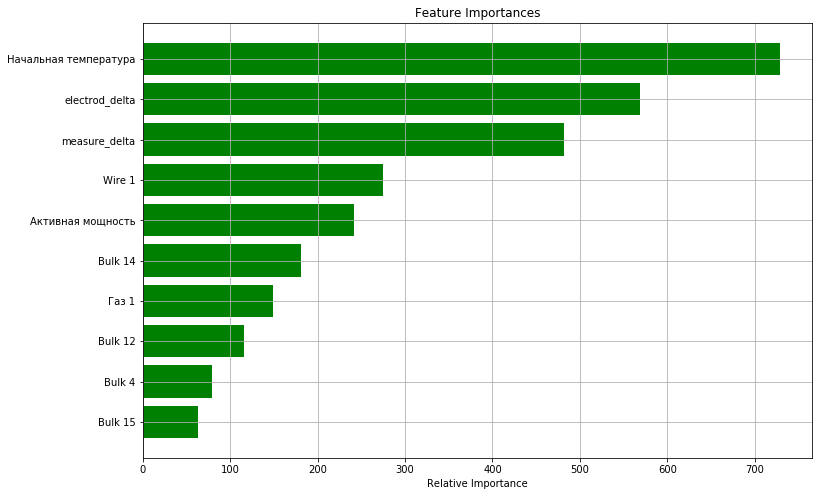

In [91]:
plot_importances(lgbm_final, 'green')

<b>Подбор гиперпараметров RandomForestRegressor</b>

In [92]:
### Оооочень много времени, поэтому закомментил
#tuned_parameters = param_grid = { 
#            "n_estimators"      : np.arange(20, 100, 10),
#            "max_features"      : ["auto", "sqrt", "log2"],
#            "min_samples_split" : [0.1, 0.2, 0.4, 0.8, 2],
#            "min_samples_leaf" : [2, 4, 5],
#            "max_depth" : [1, 2, 3],
#            "bootstrap": [True, False],
#            }
#fold = KFold(n_splits=5, shuffle=True)
#rand_mod = RandomForestRegressor(random_state=1668)
#rand_clf = GridSearchCV(rand_mod, tuned_parameters, cv=fold, scoring='neg_mean_absolute_error', 
#                        n_jobs=-1, verbose=1)
#rand_clf.fit(X_train, y_train)
#display(abs(rand_clf.best_score_))
#display(rand_clf.best_params_)

<b>RandomForestRegressor и метрика с гиперпараметрами</b>

6.841888717232232

{'bootstrap': True, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 60}

In [93]:
df_model.loc[2, 'MAE(hyperparameters)'] = 6.84

In [94]:
%%time
rf_final = RandomForestRegressor(bootstrap=True, max_features='auto', min_samples_leaf=5, 
                                 min_samples_split=2, max_depth=3,
n_estimators=70, random_state=9999)
rf_final.fit(X_train, y_train)
rf_pred = rf_final.predict(X_test)
rf_final_metric = mean_absolute_error(y_test, rf_pred)
display(rf_final_metric)
df_model.loc[2, 'MAE(Test)'] = rf_final_metric

6.54678276963092

CPU times: user 209 ms, sys: 3.19 ms, total: 212 ms
Wall time: 211 ms


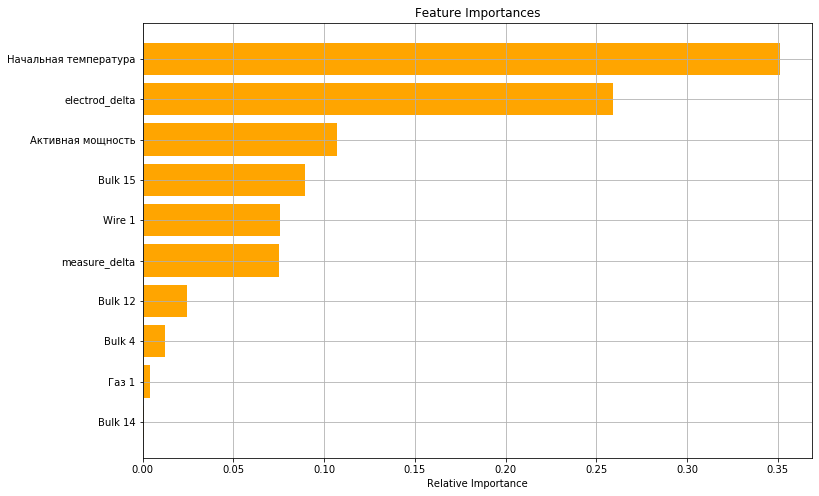

In [95]:
plot_importances(rf_final, 'orange')

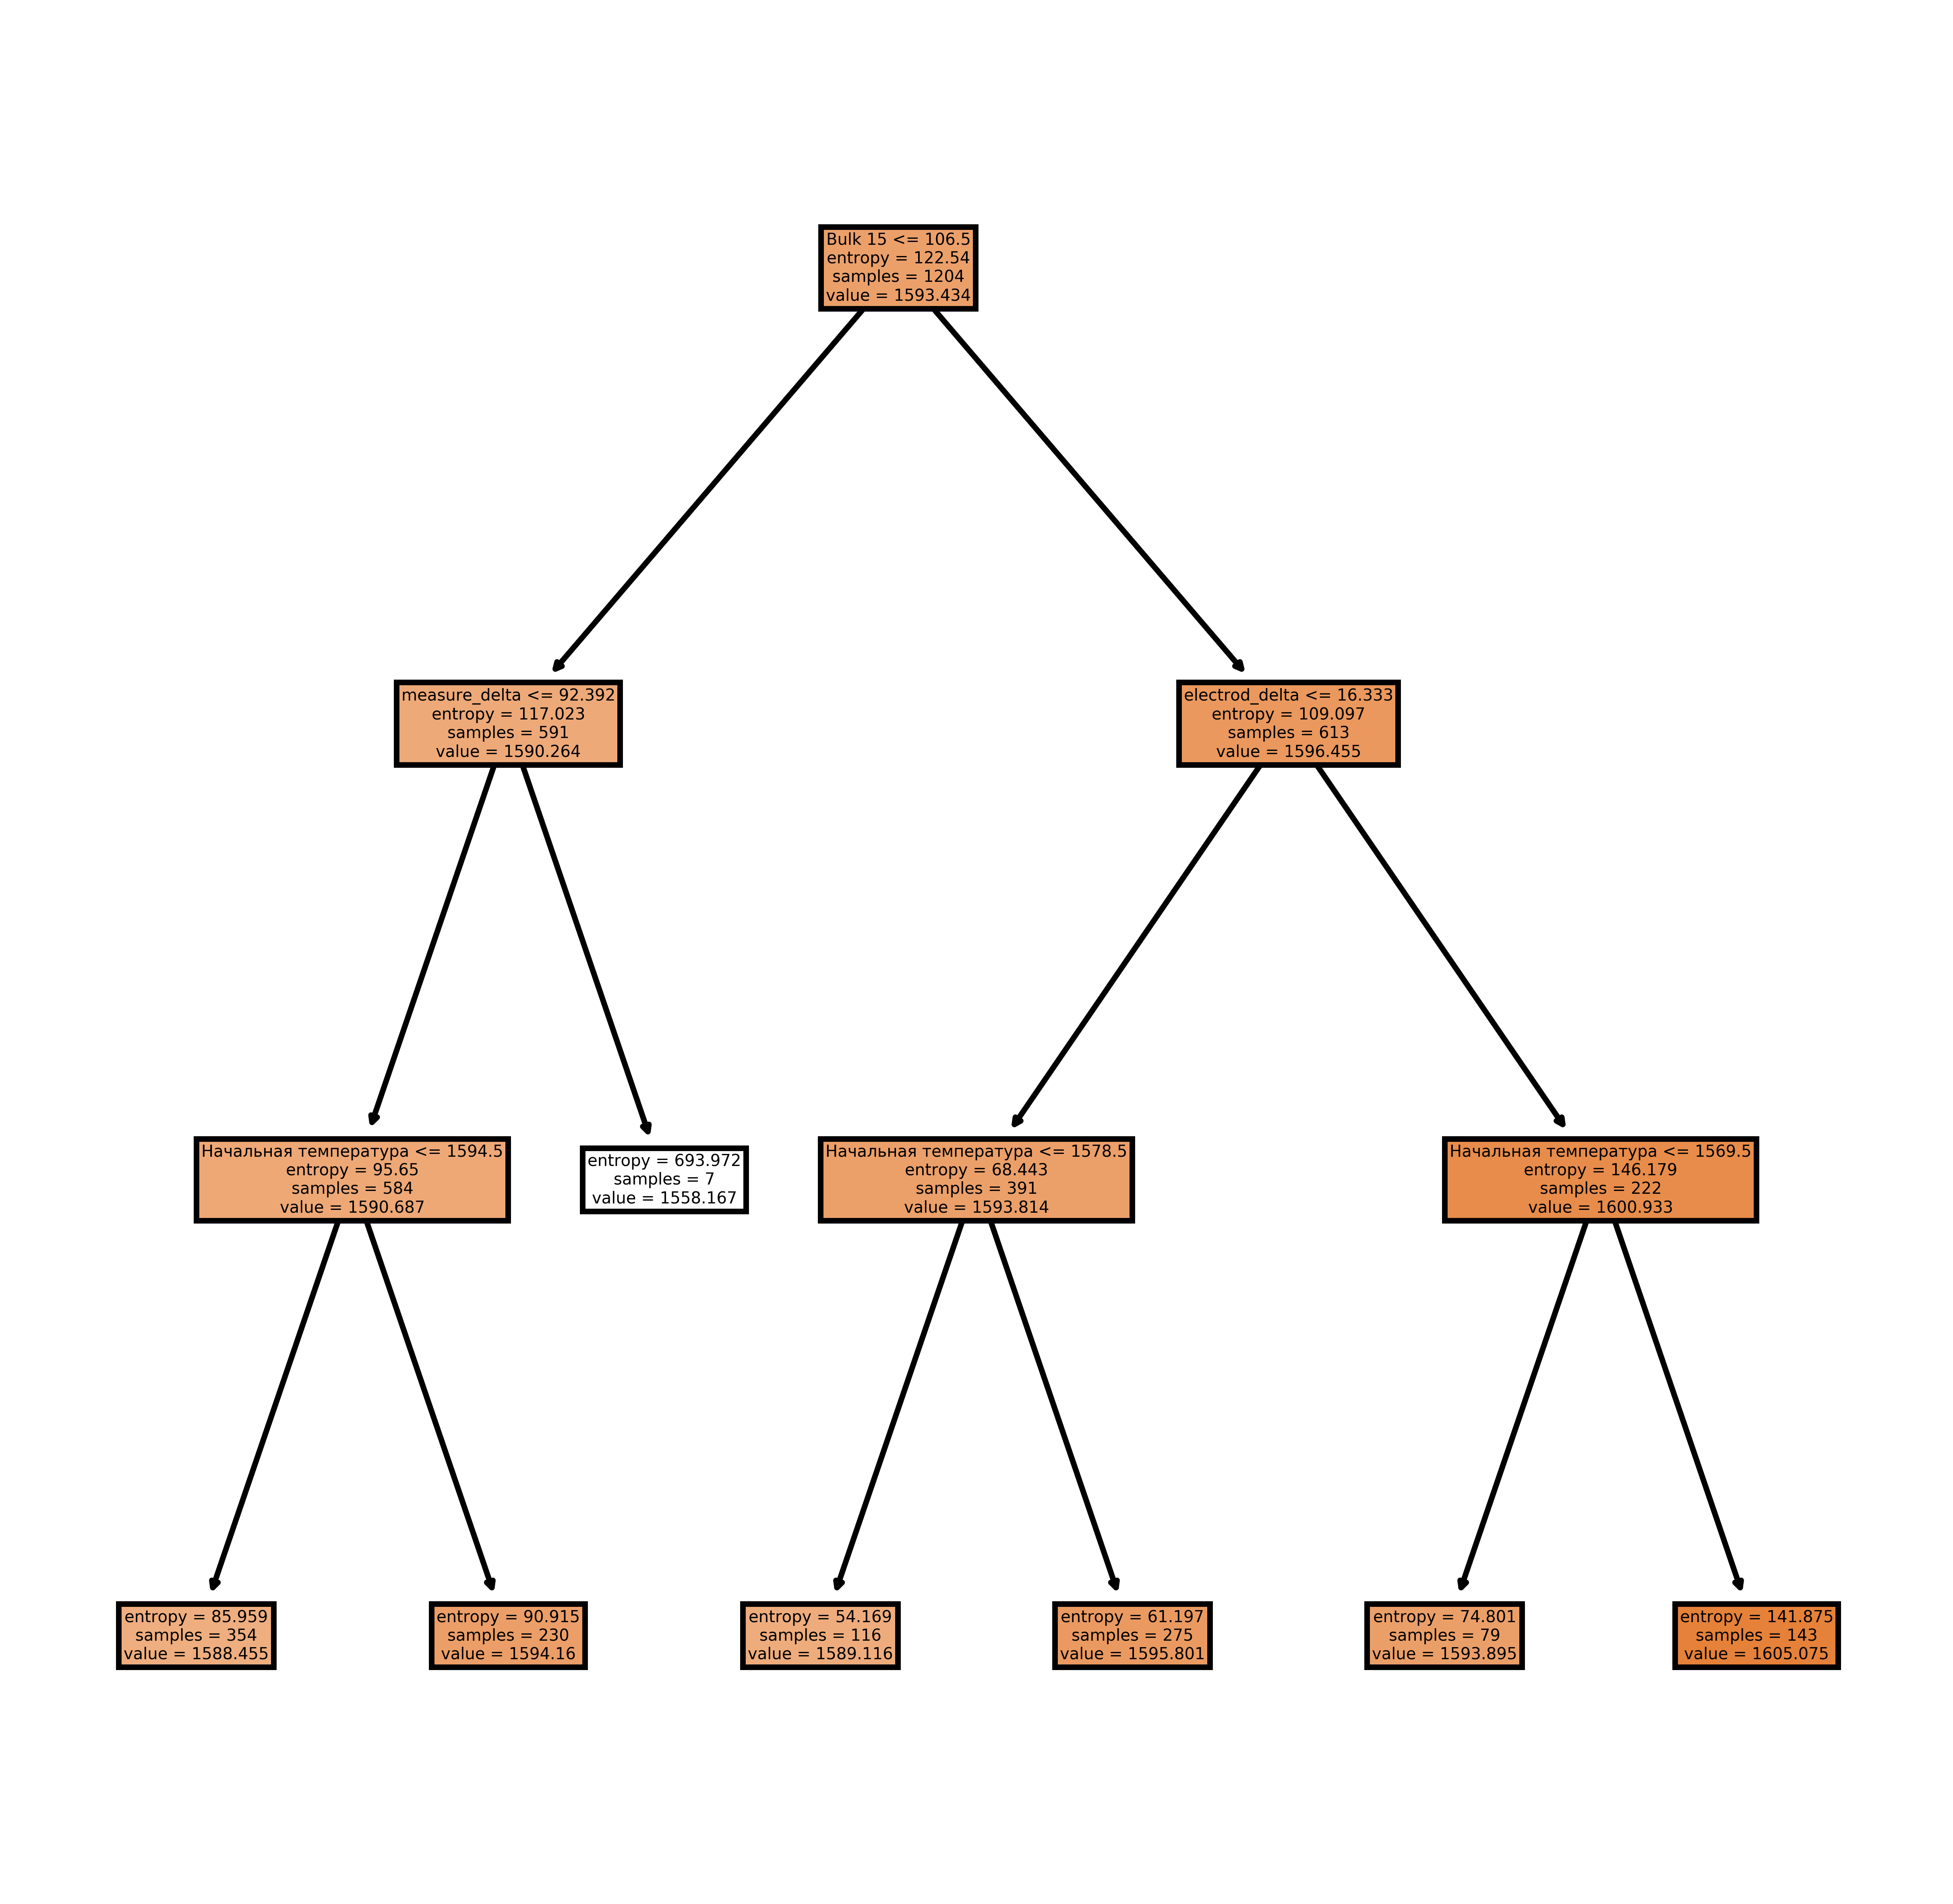

In [96]:
fn=X_train.columns
cn='Конечная температура'
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=1000)
tree.plot_tree(rf_final.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
#fig.savefig('rf_individualtree.png')

<b>Подбор параметров для XGBRegressor</b>

In [97]:
### Оооочень много времени, поэтому закомментил
#xgb_parameters = {
#    'learning_rate': [0.1, 0.03, 0.003],
#    'max_depth': [1, 2, 3],
#    'n_estimators': [50, 100, 200, 500, 750, 1000],
#}
#fold = KFold(n_splits=5, shuffle=True)
#xgb_mod = XGBRegressor(random_state=670)
#xgb_clf = GridSearchCV(xgb_mod, xgb_parameters, cv=fold, scoring='neg_mean_absolute_error', 
#                        n_jobs=-1, verbose=1)
#xgb_clf.fit(X_train, y_train)
#display(abs(xgb_clf.best_score_))
#display(xgb_clf.best_params_)

<b>XGBRegressor, метрика и гиперпараметры</b>

5.859651889725805

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 750}

In [145]:
#fig = plot_cv_results(xgb_clf.cv_results_, 'max_depth', 'learning_rate')

In [98]:
df_model.loc[7, 'MAE(hyperparameters)'] = 5.85

In [99]:
%%time
xgb_final = XGBRegressor(learning_rate=0.03, max_depth=3, n_estimators=750, random_state=29999)
xgb_final.fit(X_train, y_train)
xgb_pred = xgb_final.predict(X_test)
xgb_fin_metric = mean_absolute_error(y_test, xgb_pred)
display(xgb_fin_metric)
df_model.loc[7, 'MAE(Test)'] = xgb_fin_metric

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[08:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


4.213621496775794

CPU times: user 781 ms, sys: 0 ns, total: 781 ms
Wall time: 787 ms


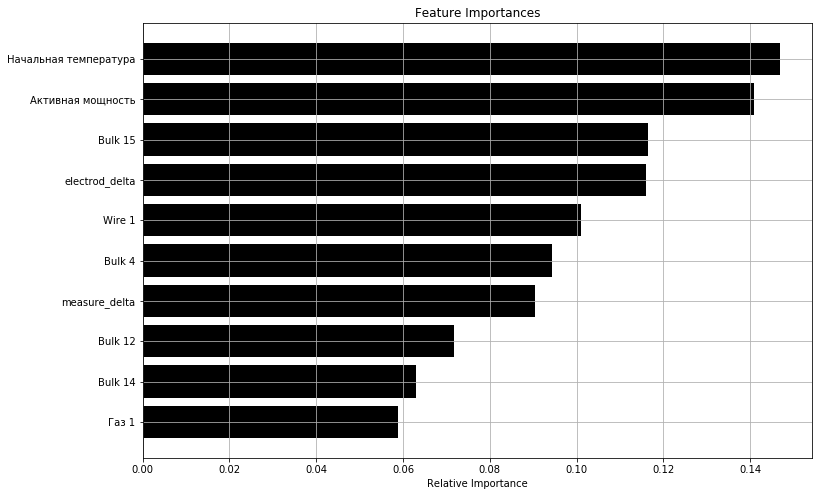

In [100]:
plot_importances(xgb_final, 'black')

<b>Подбор гиперпараметров для CatBoostRegressor</b>

In [101]:
#cat_prefinal = CatBoostRegressor(loss_function = 'RMSE', eval_metric = 'MAE', silent=True, 
#                                 random_state=59999)
#cat_grid = {'learning_rate': [0.1, 0.03, 0.003],
#        'depth': [1, 2, 3],
#        'n_estimators': [50, 100, 200, 500, 750, 1000]}
#grid_search_result = cat_prefinal.grid_search(cat_grid, X=scaled_features, y=y_train, plot=True)
#display(grid_search_result['params'])

In [102]:
#grid_search_result.values()

<b>CatBoostRegressor и её гиперпараметры</b>

{'depth': 2, 'iterations': 1000, 'learning_rate': 0.1}

In [103]:
%%time
cat_final = CatBoostRegressor(depth=2, iterations=1000,  eval_metric = 'MAE', silent=True, 
                              learning_rate=0.1, random_state=79999)
cat_final.fit(X_train, y_train)
cat_pred = cat_final.predict(X_test)
cat_fin_metric = mean_absolute_error(y_test, cat_pred)
display(cat_fin_metric)
df_model.loc[8, 'MAE(Test)'] = cat_fin_metric

4.35477617752804

CPU times: user 4.2 s, sys: 398 ms, total: 4.6 s
Wall time: 5.82 s


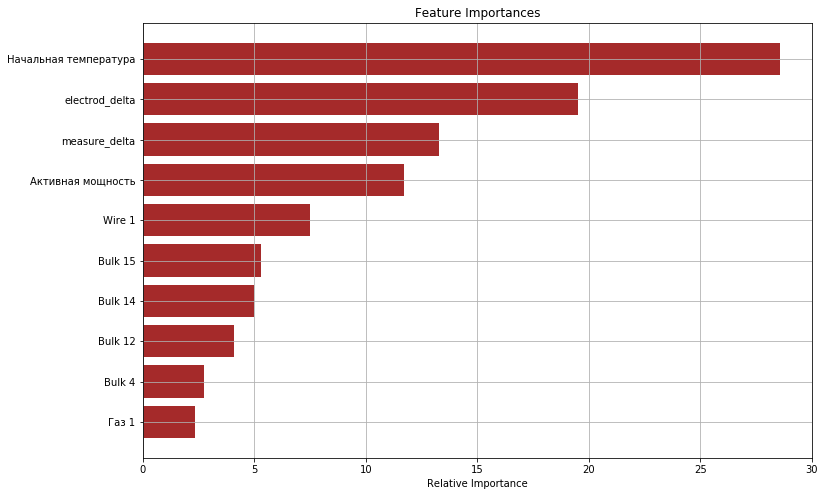

In [104]:
plot_importances(cat_final, 'brown')

<b>Таблица производительности и качества моделей(hyperparameter search)</b>

In [141]:
display(df_model.sort_values('MAE(Test)'))

,Model,MAE(cross_val_score),MAE(hyperparameters),MAE(Test)
7,XGBRegressor,6.054688,5.851562,4.214844
8,CatBoostRegressor,5.765625,NaN,4.355469
5,LGBMRegressor,5.980469,5.859375,4.664062
10,Нейронная сеть,5.738281,6.230469,5.746094
0,LinearRegression,6.042969,6.089844,6.000000
2,RandomForestRegressor,6.031250,6.839844,6.546875
1,DecisionTreeRegressor,8.640625,NaN,NaN
3,RidgeCV,6.042969,NaN,NaN
4,KNeighborsRegressor,6.753906,NaN,NaN
6,SGDRegressor,inf,NaN,NaN


## Финальная модель и выводы

* XGBRegressor: была - 5.85, стала - 4.21. Она выиграла у CatBoostRegressor
    * Признаки по важности: Начальная температура, Мощность, Bulk 15
* CatBoostRegressor: была - 5.76, стала - 4.35
    * Признаки по важности: Начальная температура, electrod_delta, measure_delta

<b>Выводы: Каждая модель интерпретируема и быстро выполняет расчёты. По интерпретируемости выделил два признака: Начальная температура и electrod_delta и measure_delta - они самые частые у четырёх моделей. 

<b>Без синтетики в фичах, при заданном выше пайплайне получилось следующее:</b>

* RandomForestRegressor: было - 7.13, стало - 4.30
    * Топ 3 признака: Начальная температура, Wire 1, Газ 1
* LGBMRegressor: было - 7.24, стало - 5.89
    * Топ 3 признака: Bulk 14, Газ 1, Wire 1
* XGBRegressor: было - 7.68, стало - 6.05
    * Топ 3 признака: Начальная температура, Bulk 15, Bulk 12
* CatBoostRegressor: было - 7.19, стало - 6.69
    * Топ 3 признака: Начальная температура, Bulk 15, Wire 1
* Нейронная сеть: стало - 	7.03

<b>Использованные фичи:</b> Начальная температура, Bulk 15, Bulk 14, Bulk 12, Bulk 4, Bulk 3, Wire 1, Газ 1

Линейная регрессия, с подбором коэффицентов на исходных фичах даёт такую важность(метрика 7.14):

* Начальная температура, Газ 1, Bulk 3, Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 1

<b>Особенности легированной стали, взято из статьи: https://svarkaipayka.ru/material/stal/temperatura-plavleniya-stali.html</b>

В состав легированных соединений вводят дополнительные компоненты. В определенных количествах они придают им требуемые свойства. В зависимости от концентрации таких элементов они подразделяются на следующие виды:

низколегированные (с концентрацией 2,5%);
среднелегированные (до 10%);
высоколегированные (свыше 10%).
За счет добавления дополнительных компонентов удается повысить прочность, коррозийную стойкость и улучшить другие характеристики. В качестве легирующих компонентов выступают хром, медь, никель, азот, ванадий и пр. 

<b>Температура плавления легированной стали колеблется в пределах 1400°С-1480°С</b>

<b>Вывод:</b>Температура плавления стали находится в промежутке 1350°С-1600°С. Но существуют и особо тугоплавкие металлы (молибден, вольфрам и пр.), способные переходить из одного состояния в другое только при нагреве свыше 2000°С. Данный показатель определяется наличием легирующих элементов и примесей, определяющих их способность к расплавлению

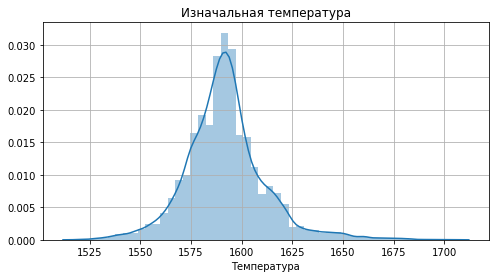

In [147]:
plt.figure(figsize=(8, 4))
sns.distplot(data_temp.query('Температура > 1000')['Температура'])
plt.title('Изначальная температура')
plt.grid()
plt.show()

In [107]:
display(len(data_temp.query('Температура < 1500')))
display(len(data_temp.query('Температура > 1640')))

0

322

In [108]:
lower = data_temp['Температура'].quantile(q=0.025)
upper = data_temp['Температура'].quantile(q=0.975)
print("97.5%-квантиль:", upper)
print("2.5%-квантиль:", lower)

97.5%-квантиль: 1640.0
2.5%-квантиль: 1554.0


Исходя из статьи про металлы поставлю нижнюю границу вопреки нижнему квартилю - <b>1350 градусов</b>(и её ловить, как критическую отметку), а верхнюю границу сделаю <b>1640 градусов</b>(критическая граница для не тугоплавких металлов, но возможно если получится узнать информацию о перечне сплавов - это уж точно не конфиденциально...)

Тогда можно будет расширить диапазон модели - всё таки этап внедрения и одобрения нужно решать с бизнесом). А пока что руководствуясь диапазоном легированной стали сделаю исходя из распределения температуры

Полную мощность заменил на Активную мощность, а Bulk 3, Количество итераций(в прошлый раз он был аутсайдером по важности) заменил на electrod_delta и measure_delta

<div style="background: #abeecc; padding: 5px; border-radius: 5px;">
    <font color='blue'> <b><u>Финальное решение</u></b>
</font>
<font color='black'><br>
Победу отдам 
<b>XGBRegressor	- 4.21, а CatBoostRegressor - 4.35</b> или LinearRegression можно будет включить в АБ тестирование, Чтобы в дальнейшем, на новых данных выявить качественную и надёжную модель. 